In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

1. Nuskaitome duomenų failą ir pažiūrime kiek turime duomenų

In [3]:
berlin = pd.read_csv('berlin_airbnb_data.csv')

In [4]:
print('Stebėjimų skaičius duomenų rinkinyje:',berlin.shape[0])

Stebėjimų skaičius duomenų rinkinyje: 22552


In [5]:
print('Skirtingų parametrų kiekvienam stebėjimui:',berlin.shape[1])

Skirtingų parametrų kiekvienam stebėjimui: 96


2. Iš 96 stulpelių atsirenkame aktualiausius duomenis analizei

In [6]:
berlin = pd.DataFrame(berlin, columns = ['property_type','room_type','accommodates','bedrooms','square_feet','price','neighbourhood_group_cleansed'])
berlin.head()

,property_type,room_type,accommodates,bedrooms,square_feet,price,neighbourhood_group_cleansed
0,Guesthouse,Entire home/apt,3,1.0,NaN,$60.00,Mitte
1,Apartment,Private room,2,1.0,NaN,$17.00,Pankow
2,Apartment,Entire home/apt,4,1.0,720.0,$90.00,Pankow
3,Apartment,Private room,2,1.0,0.0,$26.00,Tempelhof - Schöneberg
4,Apartment,Private room,2,1.0,NaN,$42.00,Pankow


3. Tvarkome duomenis: išsirenkame tik tas nuomuojamas vietas, kurių yra nurodytas dydis ir kvadratines pėdas paverčiame į kvadrtinius metrus priskirdami reikšmes naujame stulpelyje

In [7]:
berlin=berlin[berlin.square_feet>0]

In [8]:
berlin['square_meters']=berlin.square_feet.values*0.092903
berlin.square_meters=berlin.square_meters.astype(int)
berlin.head()

,property_type,room_type,accommodates,bedrooms,square_feet,price,neighbourhood_group_cleansed,square_meters
2,Apartment,Entire home/apt,4,1.0,720.0,$90.00,Pankow,66
14,Apartment,Entire home/apt,5,1.0,753.0,$160.00,Mitte,69
18,Apartment,Entire home/apt,8,2.0,1012.0,$197.00,Pankow,94
28,Apartment,Private room,1,1.0,646.0,$25.00,Tempelhof - Schöneberg,60
33,Loft,Private room,2,1.0,215.0,$50.00,Friedrichshain-Kreuzberg,19


4. Kainos reikšmės yra "Object" tipo todėl atliekam konvertavimą į skaitines reikšmes

In [9]:
berlin.price = berlin.price.str.replace(',','')

In [10]:
def doleraizeris(x):
    x = float(x[1:-1])
    return(x)
berlin.price = berlin.price.apply(doleraizeris)

5. Pašaliname išskirtis iš kainos ir objekto dydžių stulpelių

In [11]:
from scipy import stats

berlin = berlin[(np.abs(stats.zscore(berlin[['price','square_meters']])) < 3).all(axis=1)]
berlin.shape

(313, 8)

6. Kambario tipą ir rajonus suskirstome į TRUE(1) ir FALSE(0) reikšmes, nes vėliau jas įtrauksime į reikšmių nuomos kainai analizę

In [12]:
berlin['room_type2'] = berlin.room_type == 'Entire home/apt'

In [13]:
berlin['city_center'] = berlin.neighbourhood_group_cleansed == 'Mitte'

In [14]:
berlin.room_type2 = berlin.room_type2.astype(int)

In [15]:
berlin.city_center = berlin.city_center.astype(int)
berlin.head()

,property_type,room_type,accommodates,bedrooms,square_feet,price,neighbourhood_group_cleansed,square_meters,room_type2,city_center
2,Apartment,Entire home/apt,4,1.0,720.0,90.0,Pankow,66,1,0
14,Apartment,Entire home/apt,5,1.0,753.0,160.0,Mitte,69,1,1
18,Apartment,Entire home/apt,8,2.0,1012.0,197.0,Pankow,94,1,0
28,Apartment,Private room,1,1.0,646.0,25.0,Tempelhof - Schöneberg,60,0,0
33,Loft,Private room,2,1.0,215.0,50.0,Friedrichshain-Kreuzberg,19,0,0


7. Patikriname duomenų tipus ir kokių duomenų turime po jų sutvarkymo

In [16]:
berlin.dtypes

property_type                    object
room_type                        object
accommodates                      int64
bedrooms                        float64
square_feet                     float64
price                           float64
neighbourhood_group_cleansed     object
square_meters                     int32
room_type2                        int32
city_center                       int32
dtype: object

In [17]:
berlin.property_type.value_counts()

Apartment            277
Loft                  10
House                 10
Condominium            7
Guesthouse             2
Guest suite            2
Other                  2
Bungalow               1
Bed and breakfast      1
Island                 1
Name: property_type, dtype: int64

In [18]:
berlin.room_type.value_counts()

Entire home/apt    227
Private room        85
Shared room          1
Name: room_type, dtype: int64

In [19]:
berlin.neighbourhood_group_cleansed.value_counts()

Friedrichshain-Kreuzberg    72
Mitte                       70
Pankow                      57
Neukölln                    34
Charlottenburg-Wilm.        33
Tempelhof - Schöneberg      20
Treptow - Köpenick          10
Lichtenberg                  7
Reinickendorf                5
Steglitz - Zehlendorf        5
Name: neighbourhood_group_cleansed, dtype: int64

In [20]:
berlin['district'] = berlin['neighbourhood_group_cleansed'].replace(['Friedrichshain-Kreuzberg','Mitte','Pankow','Neukölln','Charlottenburg-Wilm.','Tempelhof - Schöneberg','Treptow - Köpenick','Lichtenberg','Reinickendorf','Steglitz - Zehlendorf'],['1','2','3','4','5','6','7','8','9','10'])
berlin

,property_type,room_type,accommodates,bedrooms,square_feet,price,neighbourhood_group_cleansed,square_meters,room_type2,city_center,district
2,Apartment,Entire home/apt,4,1.0,720.0,90.0,Pankow,66,1,0,3
14,Apartment,Entire home/apt,5,1.0,753.0,160.0,Mitte,69,1,1,2
18,Apartment,Entire home/apt,8,2.0,1012.0,197.0,Pankow,94,1,0,3
28,Apartment,Private room,1,1.0,646.0,25.0,Tempelhof - Schöneberg,60,0,0,6
33,Loft,Private room,2,1.0,215.0,50.0,Friedrichshain-Kreuzberg,19,0,0,1
35,Apartment,Private room,2,1.0,452.0,40.0,Pankow,41,0,0,3
39,Apartment,Private room,2,1.0,807.0,42.0,Treptow - Köpenick,74,0,0,7
42,Loft,Entire home/apt,2,1.0,474.0,48.0,Mitte,44,1,1,2
44,Apartment,Entire home/apt,2,1.0,431.0,70.0,Pankow,40,1,0,3
48,Apartment,Entire home/apt,2,1.0,323.0,90.0,Mitte,30,1,1,2


In [21]:
berlin.district.dtype

dtype('O')

In [22]:
berlin.district = berlin.district.astype(int)
berlin.dtypes

property_type                    object
room_type                        object
accommodates                      int64
bedrooms                        float64
square_feet                     float64
price                           float64
neighbourhood_group_cleansed     object
square_meters                     int32
room_type2                        int32
city_center                       int32
district                          int32
dtype: object

In [23]:
berlin.price.describe()

count    313.000000
mean      70.801917
std       40.041073
min       19.000000
25%       45.000000
50%       64.000000
75%       85.000000
max      235.000000
Name: price, dtype: float64

8. Nusibrėžiame kainos, gyventojų skaičiaus, ploto ir rajono histogramas

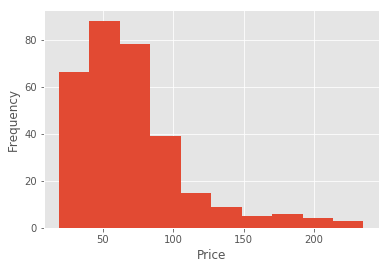

In [24]:
plt.hist(berlin.price, bins = 10)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

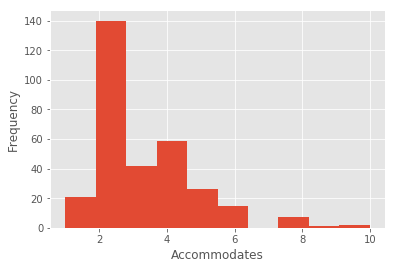

In [25]:
plt.hist(berlin.accommodates, bins = 10)
plt.xlabel("Accommodates")
plt.ylabel("Frequency")
plt.show()

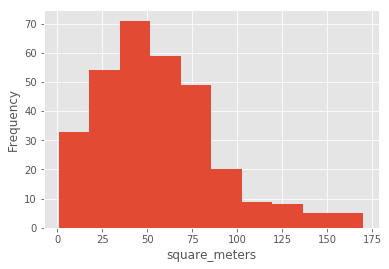

In [26]:
plt.hist(berlin.square_meters, bins = 10)
plt.xlabel("square_meters")
plt.ylabel("Frequency")
plt.show()

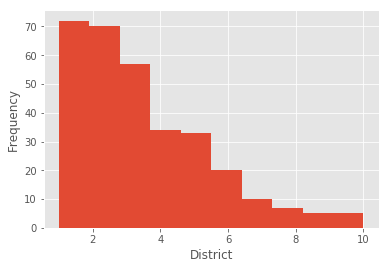

In [27]:
plt.hist(berlin.district, bins = 10)
plt.xlabel("District")
plt.ylabel("Frequency")
plt.show()

9. Tikriname kaip parametrai korealiuoja tarpusavyje

In [28]:
berlin.corr()

,accommodates,bedrooms,square_feet,price,square_meters,room_type2,city_center,district
accommodates,1.000000,0.623548,0.541585,0.542447,0.542740,0.334229,0.082550,-0.031098
bedrooms,0.623548,1.000000,0.579474,0.506213,0.579702,0.207543,0.060343,-0.030471
square_feet,0.541585,0.579474,1.000000,0.571333,0.999907,0.374562,0.096652,-0.048137
price,0.542447,0.506213,0.571333,1.000000,0.572922,0.344627,0.192345,-0.151513
square_meters,0.542740,0.579702,0.999907,0.572922,1.000000,0.376429,0.096623,-0.047915
room_type2,0.334229,0.207543,0.374562,0.344627,0.376429,1.000000,0.038359,-0.051282
city_center,0.082550,0.060343,0.096652,0.192345,0.096623,0.038359,1.000000,-0.318940
district,-0.031098,-0.030471,-0.048137,-0.151513,-0.047915,-0.051282,-0.318940,1.000000


In [29]:
berlin.corr().iloc[3,].sort_values()

district        -0.151513
city_center      0.192345
room_type2       0.344627
bedrooms         0.506213
accommodates     0.542447
square_feet      0.571333
square_meters    0.572922
price            1.000000
Name: price, dtype: float64

10. Kadangi didžiausia korealiacija su kaina tarp ploto ir galinčių gyventi asmenų skaičiaus toliau analizuojame duomenis ir brėžiame taškines diagramas

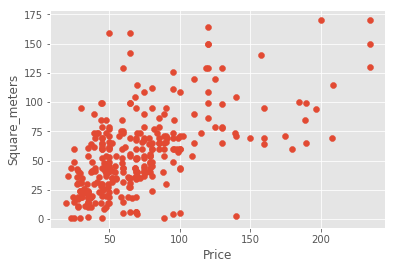

In [30]:
plt.scatter(berlin.price,berlin.square_meters)
plt.xlabel("Price")
plt.ylabel("Square_meters")
plt.show()

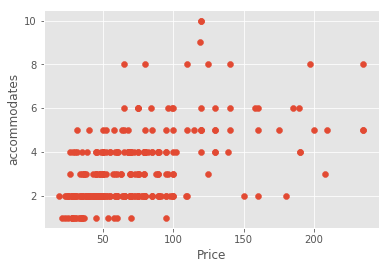

In [31]:
plt.scatter(berlin.price,berlin.accommodates)
plt.xlabel("Price")
plt.ylabel("accommodates")
plt.show()

11. Atsiskirkite visus duomenis į train ir test (Test - 20%). Duomenis atskiriame vienalypei regresijai

In [32]:
berlin.head()

,property_type,room_type,accommodates,bedrooms,square_feet,price,neighbourhood_group_cleansed,square_meters,room_type2,city_center,district
2,Apartment,Entire home/apt,4,1.0,720.0,90.0,Pankow,66,1,0,3
14,Apartment,Entire home/apt,5,1.0,753.0,160.0,Mitte,69,1,1,2
18,Apartment,Entire home/apt,8,2.0,1012.0,197.0,Pankow,94,1,0,3
28,Apartment,Private room,1,1.0,646.0,25.0,Tempelhof - Schöneberg,60,0,0,6
33,Loft,Private room,2,1.0,215.0,50.0,Friedrichshain-Kreuzberg,19,0,0,1


In [33]:
size = berlin.iloc[:,7:8].values
price = berlin.price.values
sizeTrain, sizeTest, priceTrain, priceTest = train_test_split(size, price, test_size = 0.2, random_state = 42)

In [34]:
accTrain, accTest = train_test_split(berlin.iloc[:,2:3].values, test_size = 0.2, random_state = 42)

In [35]:
districtTrain, districtTest = train_test_split(berlin.iloc[:,10:11].values, test_size = 0.2, random_state = 42)

12. Sudarome tris modelius (su skirtingais X) ir patikrinkite, kuris geriausiai veikia pagal RMSE ir R^2

12.1. Modelis pagal nuomojamo objekto plotą

In [36]:
lm_size = LinearRegression()
lm_size.fit(sizeTrain, priceTrain)
lm_size.coef_

array([0.6700386])

Text(0,0.5,'Price')

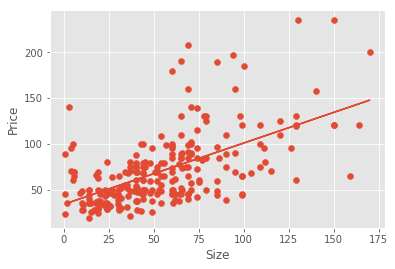

In [37]:
plt.scatter(sizeTrain, priceTrain)
plt.plot(sizeTrain, lm_size.predict(sizeTrain))
plt.xlabel('Size')
plt.ylabel('Price')

Text(0,0.5,'Price')

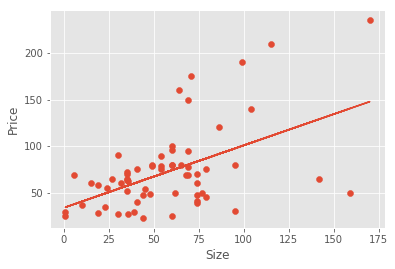

In [38]:
Predicted_size = lm_size.predict(sizeTest)
plt.scatter(sizeTest, priceTest)
plt.plot(sizeTest, Predicted_size)
plt.xlabel('Size')
plt.ylabel('Price')

12.2. Modelis pagal nuomojamame objekte galinčių apsigyventi asmenų skaičių

In [39]:
lm_acc = LinearRegression()
lm_acc.fit(accTrain, priceTrain)
lm_acc.coef_

array([13.23394313])

Text(0,0.5,'Price')

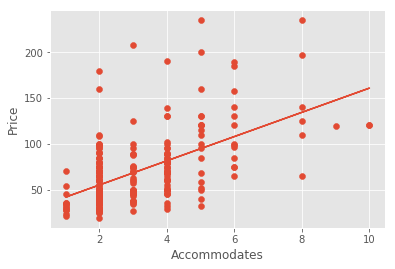

In [40]:
plt.scatter(accTrain, priceTrain)
plt.plot(accTrain, lm_acc.predict(accTrain))
plt.xlabel('Accommodates')
plt.ylabel('Price')

Text(0,0.5,'Price')

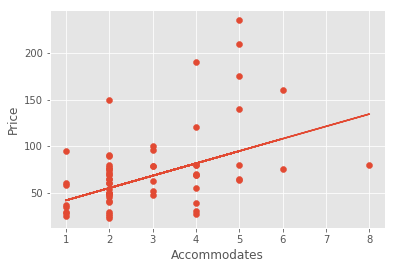

In [41]:
Predicted_acc = lm_acc.predict(accTest)
plt.scatter(accTest, priceTest)
plt.plot(accTest, Predicted_acc)
plt.xlabel('Accommodates')
plt.ylabel('Price')

12.3. Modelis pagal rajoną:

RAJONAI:
Friedrichshain-Kreuzberg    -1,
Mitte                       -2,
Pankow                      -3,
Neukölln                    -4,
Charlottenburg-Wilm.        -5,
Tempelhof - Schöneberg      -6,
Treptow - Köpenick          -7,
Lichtenberg                 -8,
Reinickendorf               -9,
Steglitz - Zehlendorf       -10,

In [42]:
lm_district = LinearRegression()
lm_district.fit(districtTrain, priceTrain)
lm_district.coef_

array([-2.62504276])

Text(0,0.5,'Price')

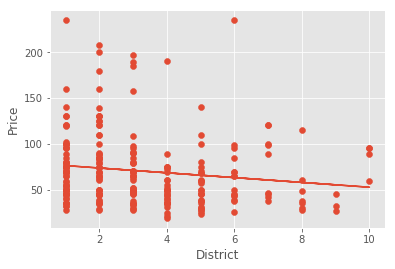

In [43]:
plt.scatter(districtTrain, priceTrain)
plt.plot(districtTrain, lm_district.predict(districtTrain))
plt.xlabel('District')
plt.ylabel('Price')

Text(0,0.5,'Price')

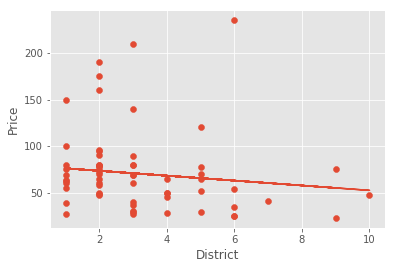

In [44]:
Predicted_district = lm_district.predict(districtTest)
plt.scatter(districtTest, priceTest)
plt.plot(districtTest, Predicted_district)
plt.xlabel('District')
plt.ylabel('Price')

12.4 Lyginame modelius

In [45]:
print(lm_size.score(sizeTrain, priceTrain), lm_acc.score(accTrain, priceTrain), lm_district.score(districtTrain, priceTrain))

0.3443036383732134 0.31860899159059797 0.021403802981194486


In [46]:
print(np.sqrt(mean_squared_error(priceTest, Predicted_size)), np.sqrt(mean_squared_error(priceTest, Predicted_acc)), np.sqrt(mean_squared_error(priceTest, Predicted_district)))

37.63355136757852 39.25909652794601 43.741509212313694


IŠVADA. Lyginant pagal pasirinktus du parametrus modelių tikslumą, matome, kad modeliai veikia panašiai ir didelio skirtumo tarp jų nėra.

13. DAUGIALYPĖ REGRESIJA. Atsiskirkite visus duomenis į train ir test (Test - 20%)

In [47]:
berlin.head()

,property_type,room_type,accommodates,bedrooms,square_feet,price,neighbourhood_group_cleansed,square_meters,room_type2,city_center,district
2,Apartment,Entire home/apt,4,1.0,720.0,90.0,Pankow,66,1,0,3
14,Apartment,Entire home/apt,5,1.0,753.0,160.0,Mitte,69,1,1,2
18,Apartment,Entire home/apt,8,2.0,1012.0,197.0,Pankow,94,1,0,3
28,Apartment,Private room,1,1.0,646.0,25.0,Tempelhof - Schöneberg,60,0,0,6
33,Loft,Private room,2,1.0,215.0,50.0,Friedrichshain-Kreuzberg,19,0,0,1


In [85]:
xTrain, xTest, yTrain, yTest = train_test_split(berlin.iloc[:,[7,8,10]].values, berlin.price.values, test_size = 0.20, random_state = 42)

In [49]:
xTrain

array([[ 24,   0,   2],
       [ 85,   1,   3],
       [ 43,   1,   9],
       [ 99,   1,   2],
       [ 71,   1,   5],
       [ 52,   1,   1],
       [ 24,   0,   3],
       [ 48,   1,   2],
       [ 74,   1,   4],
       [ 74,   0,   7],
       [ 65,   1,   2],
       [ 62,   1,   7],
       [  1,   0,   5],
       [ 65,   1,   1],
       [ 49,   1,  10],
       [ 40,   1,   1],
       [ 34,   1,   4],
       [ 57,   1,   7],
       [170,   1,   2],
       [ 24,   0,   1],
       [ 44,   1,   5],
       [ 43,   1,   3],
       [ 64,   1,   7],
       [109,   1,   1],
       [ 11,   0,   1],
       [ 85,   1,   3],
       [ 18,   0,   4],
       [ 44,   1,   5],
       [ 36,   1,   1],
       [ 61,   1,   1],
       [ 41,   1,   5],
       [ 48,   1,   7],
       [  2,   0,   1],
       [ 40,   1,   8],
       [ 60,   1,  10],
       [ 22,   0,   2],
       [ 44,   1,   2],
       [150,   1,   7],
       [ 95,   1,   1],
       [ 74,   1,   3],
       [ 54,   1,   3],
       [ 37,   1

In [86]:
lm_full = LinearRegression()
lm_full.fit(xTrain, yTrain)
lm_full.score(xTrain, yTrain)

0.36757978122910195

In [87]:
lm_full.coef_

array([ 0.59716082, 11.71148851, -1.63660574])

In [88]:
lm_full.intercept_

34.65842757141732

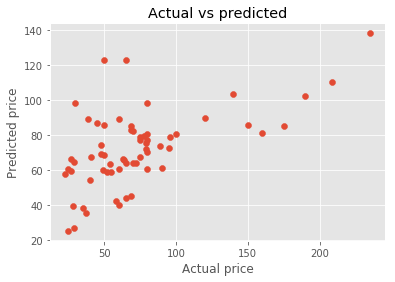

In [89]:
yhat = lm_full.predict(xTest)
plt.scatter(yTest,yhat)
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.title('Actual vs predicted')
plt.show()

In [90]:
print("Score (R^2):", lm_full.score(xTrain, yTrain))

Score (R^2): 0.36757978122910195


In [91]:
print("RMSE:", np.sqrt(mean_squared_error(yTest, yhat)))

RMSE: 36.04702901384482


IŠVADA. Bendras tendensijas įžvelgti galima, kad kaina priklauso nuo ploto (kvadratų ar kambarių/lovų skaičiaus) dydžio ir kažkiek nuo rajono, tačiau, kad modelis geriau spėliotų reikėtų įtraukti daugiau parametrų, kurie nulemia nuomos kainą. Greičiausiai tai būtų būsto įrengimas ir naujumas. Taip pat reikėt modelius išbandyti su didesniu kiekiu duomenų. Kaip galime pastebėti būsto plotas nurodomas tik kiek daugiau nei prie 1% objektų, kas pasako, kad tai nėra esminis parametras nuomos kainai.